In [1]:
import time

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from od_tutorial.model import SSD300, MultiBoxLoss
from od_tutorial.datasets import PascalVOCDataset
from od_tutorial.utils import *

from PIL import Image

In [2]:
# Data parameters
data_folder = '/data/yjkim/data/pascal/VOCdevkit/VOC2007/JPEGImages/'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
start_epoch = 0  # start at this epoch
epochs = 200  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [3]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from more_itertools import unique_everseen

In [4]:
ROOT_PATH = '/data/yjkim/data/pascal/VOCdevkit/VOC2007'
IMAGE_PATH = os.path.join(ROOT_PATH, 'JPEGImages')
ANNO_PATH = os.path.join(ROOT_PATH, 'Annotations')
SET_PATH = os.path.join(ROOT_PATH, 'ImageSets', 'Main')

In [5]:
# list image sets
all_files = !ls {SET_PATH}
image_sets = sorted(list(set([filename.replace('.txt', '').strip().split('_')[0] for filename in all_files])))
CLASSES = ['background'] + image_sets
print (CLASSES)


['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'trainval', 'tvmonitor', 'val']


In [10]:
def imgs_from_category(cat_name, dataset):
    filename = os.path.join(SET_PATH, cat_name + "_" + dataset + ".txt")
    df = pd.read_csv(
        filename,
        delim_whitespace=True,
        header=None,
        names=['filename', 'true'])
    return df

def imgs_from_category_as_list(cat_name, dataset):
    df = imgs_from_category(cat_name, dataset)
    df = df[df['true'] == 1]
    return df['filename'].values

In [12]:
train_img_list = imgs_from_category_as_list('bird', 'train')

In [151]:
img_path = os.path.join(IMAGE_PATH, '{:06d}'.format(train_img_list[4]) + '.jpg')

In [26]:
jpgfile = Image.open(img_path)
type(jpgfile)

PIL.JpegImagePlugin.JpegImageFile

In [27]:
image = Image.open(img_path, mode='r')
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [28]:
image_conv = image.convert('RGB')

In [29]:
type(image_conv)

PIL.Image.Image

In [34]:
t_ = torch.LongTensor([1,2,3,4])

In [35]:
t_typ

tensor([ 1,  2,  3,  4])

In [46]:
image

375

In [36]:
from od_tutorial.datasets import PascalVOCDataset

In [ ]:
dataset = PascalVOCDataset()

In [43]:
with open(img_path) as j:
    print(Image.open(j))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [44]:
type(t_)

_io.TextIOWrapper

In [48]:
import matplotlib.pyplot as plt
% matplotlib inline

In [81]:
new = resize(image , box )

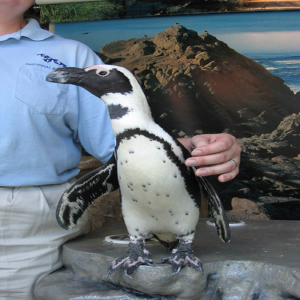

In [83]:
new[0]

In [91]:
new[1]

tensor([[ 0.1547,  0.2140,  0.7760,  0.9300]])

In [112]:
gt_boxes = np.array(new[1], dtype=np.float32)

In [113]:
# im_ = _draw_boxes_on_image(np.array(new[0]),gt_boxes)
im_ = _draw_boxes_on_image(np.array(new[0]),gt_boxes)

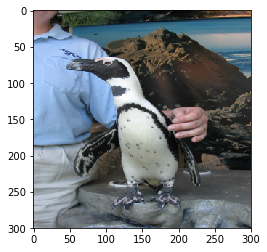

In [114]:
plt.imshow(im_)

In [107]:
for box in gt_boxes:
    print (box)

[ 58. 107. 291. 465.]


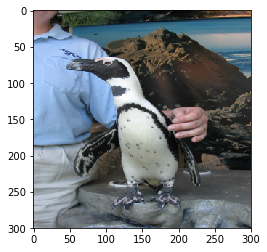

In [90]:
plt.imshow(im_)

In [55]:
resize_image, resize_box = resize(image , box )

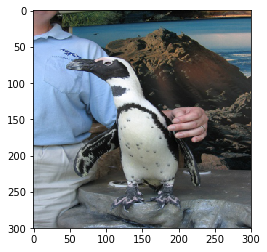

In [56]:
plt.imshow(resize_image)

In [63]:
import numpy as np

In [72]:
box = [  58,  107,  291,  465]

In [75]:
type(resize_image)

PIL.Image.Image

In [76]:
im_ = _draw_boxes_on_image(np.array(resize_image),resize_box)

In [78]:
im_.shape

(300, 300, 3)

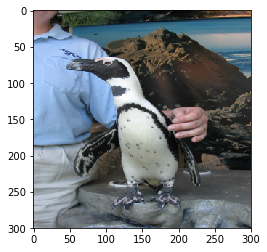

In [77]:
plt.imshow(im_)

In [62]:
import cv2

In [59]:
def _draw_boxes_on_image(img, boxes):
    _img = img.copy()
    for box in boxes:
        cv2.rectangle(_img, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 255), thickness=2)
    return _img

In [50]:
def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).

    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes

In [157]:
image = Image.open(img_path)
box = torch.Tensor([[ 330.,   11.,  454.,  368.],[  55.,   93.,  167.,  371.]])

In [158]:
new_image, new_box = resize(image,box, return_percent_coords=False)

In [160]:
new_box

tensor([[ 198.0000,    8.8000,  272.4000,  294.4000],
        [  33.0000,   74.4000,  100.2000,  296.8000]])

In [154]:
gt_boxes = np.array(new_box, dtype=np.float16)

In [155]:
d_img = _draw_boxes_on_image(np.array(new_image), gt_boxes)

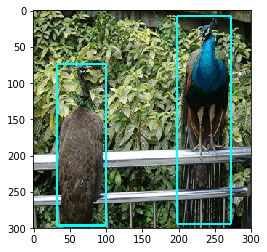

In [156]:
plt.imshow(d_img)